In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
from pathlib import Path
import pandas as pd
from src.module import Module
import torch 
from src.dm import DataModule
import torchmetrics
from tqdm import tqdm
import numpy as np

In [9]:
checkpoints = os.listdir('./checkpoints')
checkpoints

['fc_temp-epoch=99.ckpt',
 'fc_temp_resnest26d-epoch=22.ckpt',
 'fc_temp_resnet34-val_metric=0.59515-epoch=91.ckpt',
 'fc_temp_lrsch-epoch=199.ckpt',
 'fc_temp-val_metric=0.58363-epoch=89.ckpt',
 'fc_temp_resnest26d-val_metric=0.59478-epoch=21.ckpt',
 'fc_temp_resnet34-epoch=99.ckpt',
 'fc_temp_lrsch-val_metric=0.58386-epoch=67.ckpt']

In [23]:
name = "fc_temp_resnest26d-val_metric=0.59128-epoch=17.ckpt"
checkpoint = f'./checkpoints/{name}'

In [24]:
module = Module.load_from_checkpoint(checkpoint, map_location='cpu')

module.cpu()
module.eval()

traced = torch.jit.trace(module.model, torch.rand(10, 256, 256, 3, 3))
traced.save(f'kaggle-dataset/{name[:-5]}.pt')

/home/juan/.local/lib/python3.10/site-packages/einops/einops.py:316: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  known: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] != _unknown_axis_length}
/home/juan/.local/lib/python3.10/site-packages/einops/einops.py:317: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  unknown: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] == _unknown_axis_length}


In [25]:
loaded = torch.jit.load(f'kaggle-dataset/{name[:-5]}.pt')
loaded;

In [26]:
dm = DataModule(false_color=True, t=(3,4,5))
dm.setup()

loaded.eval()
loaded.cuda(1)

thresholds =  np.linspace(0.1, 0.9, 9)
dices, dices2 = [], []

for threshold in thresholds:
	metric = torchmetrics.Dice(threshold=threshold).cuda(1)
	metric2 = torchmetrics.Dice(threshold=threshold).cuda(1)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = loaded(x.cuda(1))
			metric(y_hat, y.cuda(1))
			#  put to zero all images with less than 10 pixels with value 1
			pr = torch.sigmoid(y_hat) > threshold
			pr = pr.long()
			for item in range(pr.shape[0]):
				if torch.sum(pr[item]) < 10:
					y_hat[item] = torch.zeros_like(pr[item])
			metric2(y_hat, y.cuda(1))
			pbar.set_description(f'Threshold: {threshold:.3f} Dice: {metric.compute().cpu().item():.5f} Dice (post): {np.mean(metric2).compute().cpu().item():.5f}')
	dices.append(metric.compute().cpu().item())
	dices2.append(metric2.compute().cpu().item())

data = pd.DataFrame({'threshold': thresholds, 'dice': dices, 'dice2': dices2})

Threshold: 0.100 Dice: 0.51177 Dice (post): 0.51167: 100%|██████████| 116/116 [00:26<00:00,  4.39it/s]
Threshold: 0.200 Dice: 0.51074 Dice (post): 0.51066: 100%|██████████| 116/116 [00:15<00:00,  7.62it/s]
Threshold: 0.300 Dice: 0.51011 Dice (post): 0.51001: 100%|██████████| 116/116 [00:15<00:00,  7.44it/s]
Threshold: 0.400 Dice: 0.50962 Dice (post): 0.50952: 100%|██████████| 116/116 [00:16<00:00,  7.21it/s]
Threshold: 0.500 Dice: 0.50910 Dice (post): 0.50900: 100%|██████████| 116/116 [00:16<00:00,  7.17it/s]
Threshold: 0.600 Dice: 0.50867 Dice (post): 0.50859: 100%|██████████| 116/116 [00:16<00:00,  7.12it/s]
Threshold: 0.700 Dice: 0.50816 Dice (post): 0.50793: 100%|██████████| 116/116 [00:16<00:00,  7.11it/s]
Threshold: 0.800 Dice: 0.50768 Dice (post): 0.50739: 100%|██████████| 116/116 [00:16<00:00,  7.00it/s]
Threshold: 0.900 Dice: 0.50699 Dice (post): 0.50666: 100%|██████████| 116/116 [00:17<00:00,  6.75it/s]


In [27]:
data

,threshold,dice,dice2
0,0.1,0.511769,0.511670
1,0.2,0.510735,0.510662
2,0.3,0.510115,0.510015
3,0.4,0.509618,0.509520
4,0.5,0.509100,0.509002
5,0.6,0.508667,0.508589
6,0.7,0.508155,0.507934
7,0.8,0.507677,0.507394
8,0.9,0.506990,0.506664


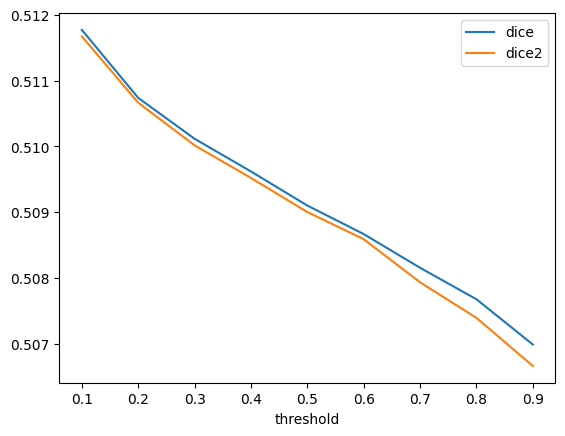

In [28]:
data.plot(x='threshold', y=['dice', 'dice2']);

In [29]:
# get threshold with max dice and dice2
data.loc[data['dice2'].idxmax()]

threshold    0.100000
dice         0.511769
dice2        0.511670
Name: 0, dtype: float64

In [96]:
path = Path('/fastdata/contrails')

records = os.listdir(path / 'test')
len(records)

2

In [97]:
stats = pd.read_csv(path/'stats.csv', index_col=0)
stats

,min,max,mean,std
8,175.82391,280.14868,233.67686,4.545741
9,180.74695,279.48690,242.25447,6.057177
10,181.44263,331.13394,250.75069,7.620164
11,179.33739,332.06036,274.41205,13.668153
12,187.69131,306.21823,255.52716,8.708825
13,179.34510,338.05670,276.60184,14.446373
14,178.71164,338.63330,275.35940,14.736154
15,178.36511,333.21048,272.56410,14.367307
16,137.39153,311.97977,260.42580,11.049050


In [98]:
import torch 
import numpy as np

def normalize_range(data, bounds):
    return (data - bounds[0]) / (bounds[1] - bounds[0])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, t=tuple(range(8)), path='/fastdata/contrails/test'):
        self.records = os.listdir(path)
        self.t = t 
        self.path = path

    def __len__(self):
        return len(self.records)
    
    def preprocess(self, record):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        b11 = np.load(f'{self.path}/{record}/band_11.npy')[..., self.t]
        b14 = np.load(f'{self.path}/{record}/band_14.npy')[..., self.t]
        b15 = np.load(f'{self.path}/{record}/band_15.npy')[..., self.t]
        r = normalize_range(b15 - b14, _TDIFF_BOUNDS)
        g = normalize_range(b14 - b11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(b14, _T11_BOUNDS)
        return np.clip(np.stack([r, g, b], axis=-1), 0, 1)
    
    def __getitem__(self, ix):
        record = self.records[ix]
        image = self.preprocess(record)
        return record, torch.from_numpy(image) # H, W, T, C

In [99]:
ds = Dataset((3,4,5))
dl = torch.utils.data.DataLoader(ds, batch_size=8, num_workers=4, pin_memory=True)

In [100]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [101]:
submission = {'record_id': [],	'encoded_pixels': []}

In [106]:
loaded.eval()
loaded.cuda(1)
with torch.no_grad():
    for records, x in dl:
        y_hat = loaded(x.cuda(1))
        masks = y_hat.sigmoid().cpu().numpy() > 0.5
        masks = masks.astype(np.int32)
        for ix in range(masks.shape[0]):
            mask = masks[ix][0] 
            if np.sum(masks[ix]) < 10:
                mask = np.zeros_like(mask)
            rle = rle_encode(mask)
            record = records[ix]
            submission['record_id'].append(record)
            if len(rle) == 0: 
                submission['encoded_pixels'].append('-')
            else:
                submission['encoded_pixels'].append(' '.join(map(str,rle)))

In [79]:
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv', index=False)
submission

,record_id,encoded_pixels
0,1002653297254493116,-
1,1000834164244036115,40709 1 40965 3 41222 4 41479 5 41737 5 41995 ...


In [80]:
!kaggle datasets version -m "update" -p kaggle-dataset

Starting upload for file fc_temp_resnet34-val_metric=0.58998-epoch=65.pt
100%|████████████████████████████████████████| 104M/104M [00:03<00:00, 29.1MB/s]
Upload successful: fc_temp_resnet34-val_metric=0.58998-epoch=65.pt (104MB)
Starting upload for file stats.csv
100%|████████████████████████████████████████████| 392/392 [00:00<00:00, 579B/s]
Upload successful: stats.csv (392B)
Starting upload for file fc_temp_resnet34-val_metric=0.59515-epoch=91.pt
100%|████████████████████████████████████████| 104M/104M [00:03<00:00, 29.5MB/s]
Upload successful: fc_temp_resnet34-val_metric=0.59515-epoch=91.pt (104MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/juansensio/contrail-models
